In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2023-02-03 12:00:27.429376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-03 12:00:27.429420: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/mike/anaconda3/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
batch_size = 32
img_height = 180
img_width = 180


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/home/mike/Downloads/archive(33)/train-cat-rabbit",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1600 files belonging to 2 classes.
Using 1280 files for training.


2023-02-03 12:02:52.335527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-03 12:02:52.335601: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-03 12:02:52.335642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mike-HP-EliteBook-Folio-9470m): /proc/driver/nvidia/version does not exist


In [6]:
train_ds.class_names

['cat', 'rabbit']

In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "/home/mike/Downloads/archive(33)/val-cat-rabbit",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 414 files belonging to 2 classes.
Using 82 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)


['cat', 'rabbit']


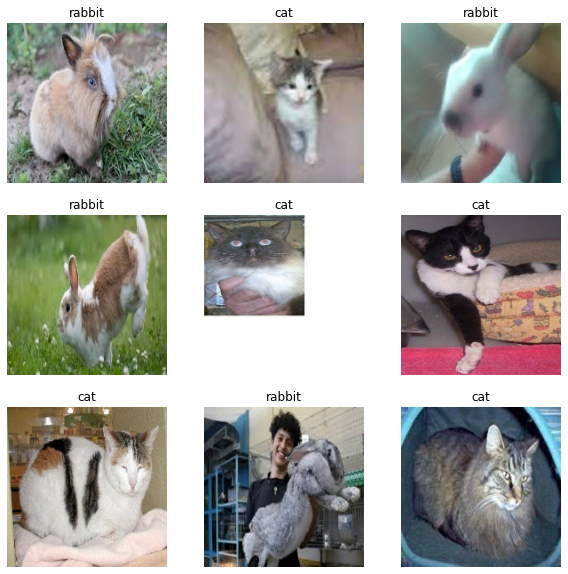

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [14]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [15]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [16]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)


Epoch 1/3


2023-02-03 12:05:30.818694: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 129777664 exceeds 10% of free system memory.
2023-02-03 12:05:31.387810: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32444416 exceeds 10% of free system memory.
2023-02-03 12:05:31.430854: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31002624 exceeds 10% of free system memory.
2023-02-03 12:05:31.889727: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29047680 exceeds 10% of free system memory.
2023-02-03 12:05:31.985535: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31002624 exceeds 10% of free system memory.


40/40 [==============================] - 56s 1s/step - loss: 0.6550 - accuracy: 0.6359 - val_loss: 0.6191 - val_accuracy: 0.6463
Epoch 2/3
40/40 [==============================] - 54s 1s/step - loss: 0.4905 - accuracy: 0.7492 - val_loss: 0.4428 - val_accuracy: 0.8049
Epoch 3/3
40/40 [==============================] - 55s 1s/step - loss: 0.4029 - accuracy: 0.8086 - val_loss: 0.4361 - val_accuracy: 0.7439
